## 강아지 품종 분류 딥러닝 모델

* http://210.115.229.18/dog_image.zip
    

## MobileNet 기반 강아지 품종 분류


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 설정

In [8]:
IMG_WIDTH = 224  
IMG_HEIGHT = 224  

root_dir = "./"
train_dir = os.path.join(root_dir, 'dog_image/train/')
validation_dir = os.path.join(root_dir, 'dog_image/train/')
test_dir = os.path.join(root_dir, 'dog_image/test/')

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, 
                                    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                    validation_split=0.15)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, color_mode='rgb', 
                                                class_mode='sparse', subset = 'training',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=16, color_mode='rgb', 
                                                          class_mode='sparse', subset = 'validation',
                                                          target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 1136 images belonging to 4 classes.
Found 198 images belonging to 4 classes.


flow_from_directory는 케라스(Keras)의 ImageDataGenerator 클래스의 메소드로, 디렉토리에서 이미지를 불러오고 실시간 데이터 증강(augmentation)을 적용하는 기능을 합니다.

디렉토리 구조는 주로 각 클래스마다 별도의 하위 디렉토리를 갖는 방식으로 구성되며, 각 하위 디렉토리에는 해당 클래스에 속하는 이미지들이 저장됩니다. 이렇게 각 클래스별로 분류된 이미지를 불러오면서 자동으로 레이블을 할당합니다.

flow_from_directory 함수의 기본적인 사용법은 다음과 같습니다:

```python
train_datagen = ImageDataGenerator(
        rescale=1./255,     # 픽셀 값을 0-1 범위로 변환
        shear_range=0.2,    # 랜덤하게 전단 변환(shear transformation)을 적용할 각도 범위
        zoom_range=0.2,     # 랜덤하게 확대/축소를 적용할 범위
        horizontal_flip=True)  # 랜덤하게 이미지를 수평으로 뒤집기

train_generator = train_datagen.flow_from_directory(
        'data/train',  # 학습 이미지가 있는 디렉토리
        target_size=(150, 150),  # 모든 이미지를 150 x 150 크기로 변경
        batch_size=32,
        class_mode='binary')  # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요

```


flow 함수는 Keras의 ImageDataGenerator 클래스의 메소드로, 넘파이 배열 및 해당 레이블에 데이터 증강을 적용한 후 배치 단위로 데이터를 제공하는 제너레이터를 생성합니다.

이 함수는 훈련 데이터를 모델에 적합하게 하기 위해 이미지 데이터에 실시간 데이터 증강(augmentation)을 적용하는 데 사용됩니다. 데이터 증강은 주로 과적합을 피하는 데 도움이 되며, 적은 양의 데이터로 다양한 변형을 적용해 훈련 데이터를 '증강'하는 기법입니다.

flow 함수의 기본적인 사용법은 다음과 같습니다:

```python
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

data_generator = datagen.flow(
    X_train, y_train,
    batch_size=32)

```
위의 코드에서 ImageDataGenerator는 다양한 변형 기법을 적용하도록 설정되어 있습니다. 그런 다음, flow 메소드를 사용하여 실제로 데이터 증강을 수행하고, 배치 단위로 데이터를 제공하는 제너레이터를 생성합니다. 이 제너레이터는 모델의 fit 메소드를 호출할 때 입력 데이터로 사용할 수 있습니다.

X_train과 y_train은 각각 이미지 데이터와 해당 레이블의 넘파이 배열을 나타냅니다. batch_size는 한 번에 생성할 이미지의 개수를 지정합니다. 이 값을 적절히 선택하면 메모리 사용량을 제어하고 훈련 속도를 최적화하는 데 도움이 됩니다.



In [11]:
print(train_generator.class_indices)

{'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}


# Transfer Learning base 모델 구축

MobileNet은 경량화된 딥 러닝 모델 구조로, 효율성과 성능 사이의 균형을 유지하면서 모바일 및 임베디드 디바이스에서 동작하는 데 특화되어 있습니다.

MobileNet의 주요 특징은 다음과 같습니다:

 * Depthwise Separable Convolution: MobileNet의 핵심 구성 요소는 depthwise separable convolution입니다. 전통적인 convolution 연산을 depthwise convolution과 pointwise convolution 두 단계로 분리해 연산량을 크게 줄입니다. 이는 모델의 사이즈를 줄이고, 계산 효율성을 높이며, 전력 소모를 감소시킵니다.

 * 실시간 처리: MobileNet은 실시간 처리를 가능하게 하는 빠른 연산 속도를 가지고 있습니다. 이는 실시간 이미지 분류, 객체 검출, 세그멘테이션 등의 작업에서 중요한 요소입니다.

 * 다양한 애플리케이션에서 사용 가능: MobileNet은 임베디드 시스템에서 사용되는 애플리케이션에서 효과적으로 작동합니다. 이에는 이미지 분류, 객체 탐지, 페이스 인식 등 다양한 태스크가 포함됩니다.

 * 파라미터 수정을 통한 효율과 성능 조정 가능: MobileNet은 두 개의 파라미터를 통해 성능과 효율성 사이의 균형을 쉽게 조정할 수 있습니다. 이는 모델의 복잡도를 조절하고 특정 장치에서 최적의 성능을 달성하는 데 도움이 됩니다.

 * 전이 학습 용이: MobileNet은 다른 많은 딥 러닝 모델과 마찬가지로 전이 학습(Transfer Learning)에 유용하게 사용될 수 있습니다. 사전에 학습된 MobileNet 모델을 feature extractor로 사용하거나, fine-tuning을 통해 특정 작업에 맞게 재학습하는 것이 가능합니다.

이런 특징들로 인해, MobileNet은 경량화가 필요한 다양한 환경에서 활용됩니다. 이에는 스마트폰, 태블릿, IoT 디바이스 등이 포함됩니다.







In [12]:
from keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

In [13]:
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))                  
model.add(Dense(4, activation='softmax'))

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4834660 (18.44 MB)
Trainable params: 4812772 (18.36 MB)
Non-trainable params: 21888 (85.50 KB)
_____________

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5)                     

hist = model.fit(train_generator, validation_data=validation_generator,
                 epochs=50, callbacks=[earlystopping])

Epoch 1/50
71/71 [==============================] - 46s 599ms/step - loss: 1.5024 - accuracy: 0.4252 - val_loss: 0.6640 - val_accuracy: 0.7727
Epoch 2/50
71/71 [==============================] - 43s 600ms/step - loss: 0.7933 - accuracy: 0.6585 - val_loss: 0.3734 - val_accuracy: 0.8535
Epoch 3/50
71/71 [==============================] - 43s 604ms/step - loss: 0.5907 - accuracy: 0.7535 - val_loss: 0.2639 - val_accuracy: 0.8990
Epoch 4/50
71/71 [==============================] - 43s 605ms/step - loss: 0.4997 - accuracy: 0.8151 - val_loss: 0.2205 - val_accuracy: 0.9293
Epoch 5/50
71/71 [==============================] - 43s 599ms/step - loss: 0.4097 - accuracy: 0.8433 - val_loss: 0.1976 - val_accuracy: 0.9343
Epoch 6/50
71/71 [==============================] - 43s 602ms/step - loss: 0.3389 - accuracy: 0.8609 - val_loss: 0.1758 - val_accuracy: 0.9293
Epoch 7/50
71/71 [==============================] - 44s 619ms/step - loss: 0.3284 - accuracy: 0.8741 - val_loss: 0.1433 - val_accuracy: 0.9394

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

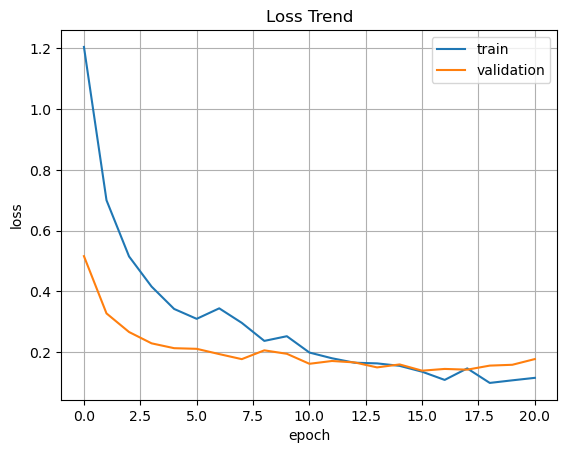

In [28]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, color_mode='rgb',
                                              class_mode='sparse', target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 146 images belonging to 4 classes.


In [31]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 216ms/step - loss: 0.1017 - accuracy: 0.9726


[0.10167665779590607, 0.9726027250289917]

In [43]:
import random
import os
import numpy as np
import cv2
import glob

label_dict = {'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}

test_image_files_list = glob.glob(root_dir+ '/dog_image/test_image_files/*.jpg')

random.shuffle(test_image_files_list)

test_num = 16
test_image_files = test_image_files_list[:test_num]  # 태스트 파일이름은 정답.숫자.jpg 

label_list = []

for i in range(len(test_image_files)):
    label = test_image_files[i].split('\\')[-1].split('.')[0].strip()
    label_list.append(label_dict[label])


src_img_list = []


for i in range(len(test_image_files)):
    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    src_img_list.append(src_img)

# 4차원 텐서  변환
src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

print(src_img_array.shape, label_array.shape)
print(label_array)

(16, 224, 224, 3) (16,)
[1 1 3 2 2 1 2 0 0 3 0 2 0 1 0 1]


In [44]:
pred = model.predict(src_img_array)
print(pred.shape)

1/1 [==============================] - 0s 407ms/step
(16, 4)


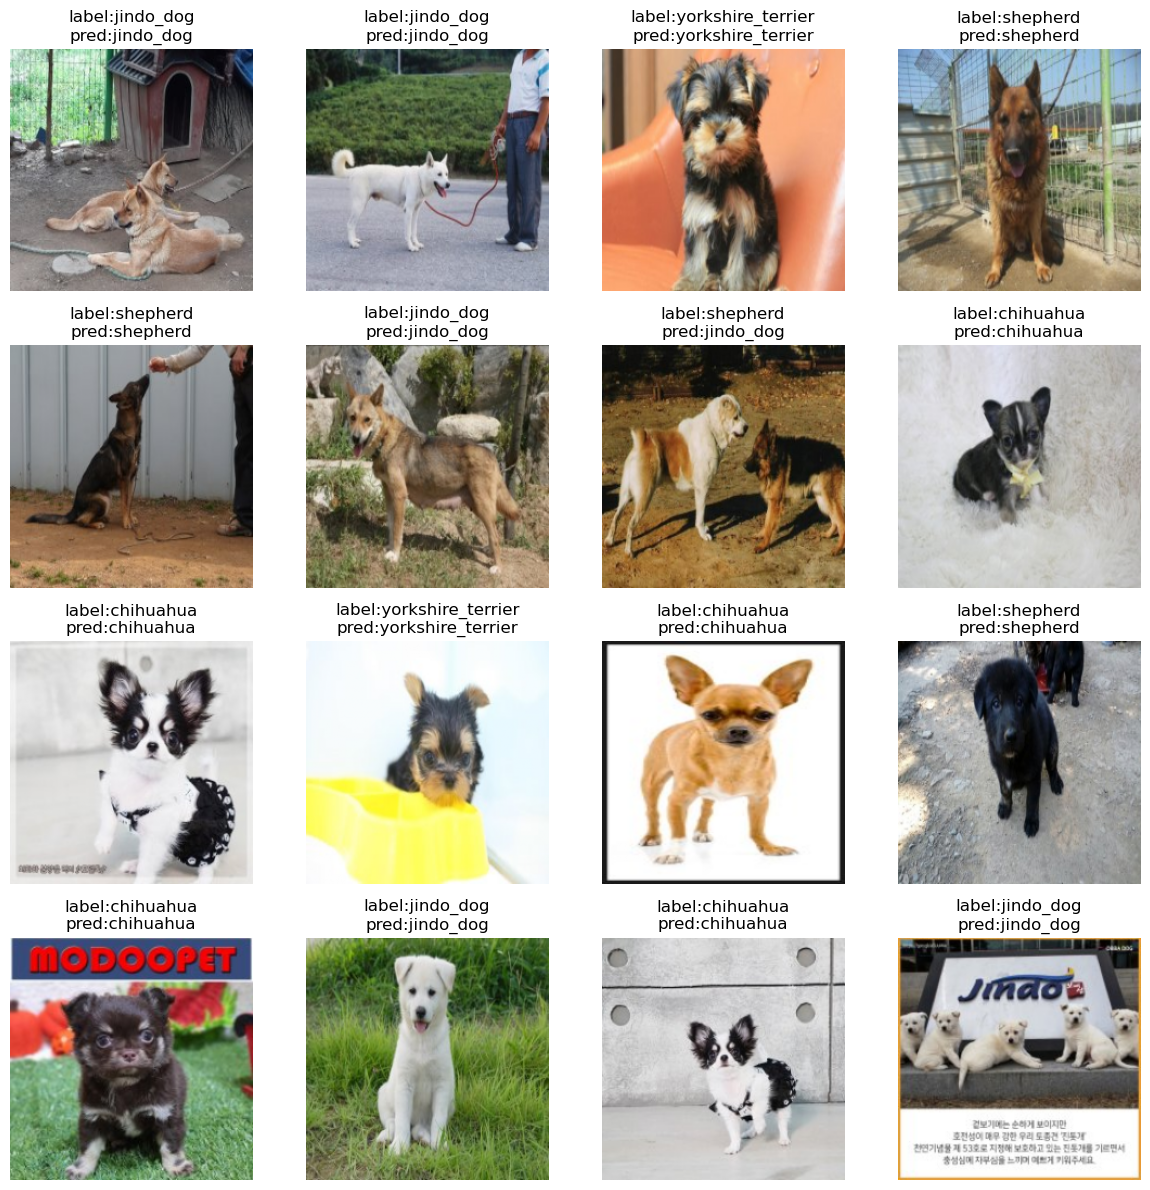

In [45]:
import matplotlib.pyplot as plt

class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(12,12))

for pos in range(len(pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()